**Imports**

In [1]:
import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score


**Carga de datos**

In [2]:
url="https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv"

data=pd.read_csv(url)
data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


**Análisis general de los datos** 

Número de variables, tipos de variables, selección de variable objetivo, tratamiento de nulos y de duplicados.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


Tenemos 108 variables, de las cuales 61 son tipo float, 45 tipo integer, y 2 tipo object, por tanto, prácticamente todas son numéricas.

Como no tenemos la descripción de cada variable, vamos a ir viendo qué puede indicarnos cada una, y el número de nulos

In [4]:
i=0
while i< len(data.columns):
    print(data.iloc[:,i:i+18].info())
    i=i+18

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fips                      3140 non-null   int64  
 1   TOT_POP                   3140 non-null   int64  
 2   0-9                       3140 non-null   int64  
 3   0-9 y/o % of total pop    3140 non-null   float64
 4   19-Oct                    3140 non-null   int64  
 5   10-19 y/o % of total pop  3140 non-null   float64
 6   20-29                     3140 non-null   int64  
 7   20-29 y/o % of total pop  3140 non-null   float64
 8   30-39                     3140 non-null   int64  
 9   30-39 y/o % of total pop  3140 non-null   float64
 10  40-49                     3140 non-null   int64  
 11  40-49 y/o % of total pop  3140 non-null   float64
 12  50-59                     3140 non-null   int64  
 13  50-59 y/o % of total pop  3140 non-null   float64
 14  60-69   

In [5]:
print(f"El número de duplicados es: {data.duplicated().sum()}")
print(f"El número de nulos es: {data.isnull().sum().sum()}")


El número de duplicados es: 0
El número de nulos es: 0


No tenemos valores nulos ni duplicados.

In [6]:
data.iloc[:,4*18:(4*18+19)].select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   COUNTY_NAME  3140 non-null   object
 1   STATE_NAME   3140 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


Las variables categóricas son COUNTY_NAME y STATE_NAME, vamos a ver si tienen relación con las variables: 
* Urban_rural_code
* STATE_FIPS
* CNTY_FIPS
* fips

In [7]:
data[["COUNTY_NAME","STATE_NAME","Urban_rural_code","STATE_FIPS","CNTY_FIPS","fips"]]

,COUNTY_NAME,STATE_NAME,Urban_rural_code,STATE_FIPS,CNTY_FIPS,fips
0,Autauga,Alabama,3,1,1,1001
1,Baldwin,Alabama,4,1,3,1003
2,Barbour,Alabama,6,1,5,1005
3,Bibb,Alabama,2,1,7,1007
4,Blount,Alabama,2,1,9,1009
...,...,...,...,...,...,...
3135,Sweetwater,Wyoming,5,56,37,56037
3136,Teton,Wyoming,5,56,39,56039
3137,Uinta,Wyoming,5,56,41,56041
3138,Washakie,Wyoming,6,56,43,56043


In [8]:
county_unique=data.groupby("COUNTY_NAME")["CNTY_FIPS"].nunique()
print(county_unique[county_unique>1])

state_unique=data.groupby("STATE_NAME")["STATE_FIPS"].nunique()
print(state_unique[state_unique>1])


COUNTY_NAME
Adams        2
Allegany     2
Allen        2
Anderson     4
Armstrong    2
            ..
Worth        3
Wright       3
Wyoming      3
York         5
Yuma         2
Name: CNTY_FIPS, Length: 429, dtype: int64
Series([], Name: STATE_FIPS, dtype: int64)


**No hay una relación** de 1-1 entre las variables **COUNTY_NAME y CNTY_FIPS**, sin embargo, **sí** que la hay entre las variables **STATE_NAME y STATE_FIPS**, por lo tanto, podemos **descartar** la variable **STATE_NAME** y nos quedamos con **STATE_FIPS** como factorización de STATE_NAME

De todas formas, **county_name, cnty_fips, fips y urban_rural_code**, son variables que van al detalle del distrito, por tanto, de momento vamos a **descartarlas** (pudiendo tenerlas en cuenta si no encontramos un estudio significativo entre el resto de variables, o pudiendo ir a más detalle si dividieramos el estudio por STATE_NAME) 

In [9]:
descarte1=["STATE_NAME","COUNTY_NAME","CNTY_FIPS","fips","Urban_rural_code"]
data1=data.drop(descarte1,axis=1,inplace=False)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 103 entries, TOT_POP to CKD_number
dtypes: float64(61), int64(42)
memory usage: 2.5 MB


**Análisis de variables numéricas**

Estudio de correlación, selección de variables de mayor impacto y visualización de relación con variable objetivo.

Vamos a empezar viendo varias cosas para reducir más el conjunto, antes de empezar con las correlaciones y análisis:
1. Si las variables edad y raza en % son el resultado de dividir la variable edad/tot_pob
2. Si la variable tot_pop y total population son la misma
3. Si la variable Aged 60+ es la suma de los grupos por encima de 60 de edad
4. Si el 95% CI lower y upper está relacionado con _prevalence o con _number


1. Las variables que indican el % de la edad y raza están entre las columnas 2 y 32, las columnas pares:

In [10]:
subdata_edad=data1.iloc[:,1:32]
result_edad=pd.DataFrame(data1.iloc[:,0])
x=[]

for i in range(30):
    if i%2!=0: 
        x.append(i)
    else:
        var=subdata_edad.columns[i]
        result_edad[var]=round((subdata_edad.iloc[:,i]/data["TOT_POP"])*100-subdata_edad.iloc[:,i+1],6)

print(x)
result_edad.head()

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]


,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,Black-alone pop,Native American/American Indian-alone pop,Asian-alone pop,Hawaiian/Pacific Islander-alone pop,Two or more races pop
0,55601,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
1,218022,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
2,24881,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
3,22400,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,57840,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0


Hemos visto que el % efectivamente es la división entre el número y la población total, por tanto, por el momento nos quedamos con los % de cada edad y raza

In [11]:
descarte2=data1.iloc[:,x].columns
data2=data1.drop(descarte2,axis=1, inplace=False)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 88 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   TOT_POP                                                                        3140 non-null   int64  
 1   0-9 y/o % of total pop                                                         3140 non-null   float64
 2   10-19 y/o % of total pop                                                       3140 non-null   float64
 3   20-29 y/o % of total pop                                                       3140 non-null   float64
 4   30-39 y/o % of total pop                                                       3140 non-null   float64
 5   40-49 y/o % of total pop                                                       3140 non-null   float64
 6   50-59 y/o % of total pop

2. Variable TOT_POP y total_population **NO** son la misma (ver código siguiente): por tanto, mantenemos las dos.

In [12]:
sum(data["TOT_POP"]-data["Total Population"])

6163125

3. "Population Aged 60+" y "Percent of Population Aged 60+" **NO** son la suma de: 60-69, 70-79, 80+ y el %:

In [13]:
var_60mas=data["60-69"]+data["70-79"]+data["80+"]
sum(var_60mas-data["Population Aged 60+"])

5806136

4. Podemos **prescindir** del rango del 95% CI (*_Lower 95% CI*, *_Upper 95% CI*) en las variables, vamos a ver si está relacionado con *_prevalence* o con *_number* 

Para las siguientes variables: **Heart disease**,**anycondition**, **Obesity**, **COPD**,**diabetes**,**CKD**

In [14]:
vars_CI=["Heart disease","anycondition", "Obesity", "COPD","diabetes","CKD"]
rel_prev=pd.DataFrame()
rel_num=pd.DataFrame()
for i in range(len(vars_CI)):
    valor_low=vars_CI[i] + "_Lower 95% CI"
    valor_upp=vars_CI[i] + "_Upper 95% CI"
    valor_prev=vars_CI[i] + "_prevalence"
    valor_num=vars_CI[i] + "_number"
    rel_prev[valor_prev]=round(data[valor_prev]-data[valor_low]+data[valor_prev]-data[valor_upp],10)
    rel_num[valor_num]=round(data[valor_num]-data[valor_low]+data[valor_num]-data[valor_upp],5)
print(rel_prev.mean(),rel_num.mean())


Heart disease_prevalence   -0.050860
anycondition_prevalence     0.091019
Obesity_prevalence          0.037771
COPD_prevalence            -0.083217
diabetes_prevalence         0.005191
CKD_prevalence             -0.025510
dtype: float64 Heart disease_number    11177.920159
anycondition_number     66677.302548
Obesity_number          50482.262229
COPD_number             11636.211051
diabetes_number         18627.013599
CKD_number               4925.550159
dtype: float64


Demostramos que la variable que va acompañada de los límites de confianza es **_prevalence**. Vamos a eliminar los límites de confianza para nuestro estudio:

In [15]:
descarte3=[val + "_Lower 95% CI" for val in vars_CI]
descarte32=[val + "_Upper 95% CI" for val in vars_CI]
descarte3.extend(descarte32)
print(descarte3)

['Heart disease_Lower 95% CI', 'anycondition_Lower 95% CI', 'Obesity_Lower 95% CI', 'COPD_Lower 95% CI', 'diabetes_Lower 95% CI', 'CKD_Lower 95% CI', 'Heart disease_Upper 95% CI', 'anycondition_Upper 95% CI', 'Obesity_Upper 95% CI', 'COPD_Upper 95% CI', 'diabetes_Upper 95% CI', 'CKD_Upper 95% CI']


In [16]:
data3=data2.drop(descarte3,axis=1,inplace=False)
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 76 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   TOT_POP                                                                        3140 non-null   int64  
 1   0-9 y/o % of total pop                                                         3140 non-null   float64
 2   10-19 y/o % of total pop                                                       3140 non-null   float64
 3   20-29 y/o % of total pop                                                       3140 non-null   float64
 4   30-39 y/o % of total pop                                                       3140 non-null   float64
 5   40-49 y/o % of total pop                                                       3140 non-null   float64
 6   50-59 y/o % of total pop

Realizamos un análisis de correlaciones para verificar si tenemos alguna variable más que podamos eliminar del dataset por correlación cercana a 1 (y que las variables indiquen los mismos datos)

In [17]:

matriz_correlacion = data3.corr()

# Convertir la matriz en una Serie para ordenar
correlacion_ordenada = matriz_correlacion.unstack().sort_values(ascending=False)

x=[]
correlacion_1=correlacion_ordenada[correlacion_ordenada>0.99]
for i in range(len(correlacion_1)):
    if correlacion_1.index[i][0]==correlacion_1.index[i][1]: continue
    else: x.append([correlacion_1.index[i][0],correlacion_1.index[i][1]])

y=sorted(x)
for val in y: print(val)

x_unique=np.unique(x)
for val in x_unique: print(val)


['CI90LBINC_2018', 'MEDHHINC_2018']
['CI90LBINC_2018', 'Median_Household_Income_2018']
['CI90UBINC_2018', 'MEDHHINC_2018']
['CI90UBINC_2018', 'Median_Household_Income_2018']
['CKD_number', 'COPD_number']
['CKD_number', 'Heart disease_number']
['CKD_number', 'POP_ESTIMATE_2018']
['CKD_number', 'Population Aged 60+']
['CKD_number', 'TOT_POP']
['CKD_number', 'Total Population']
['CKD_number', 'anycondition_number']
['CKD_number', 'county_pop2018_18 and older']
['CKD_number', 'diabetes_number']
['COPD_number', 'CKD_number']
['COPD_number', 'Heart disease_number']
['COPD_number', 'High school diploma only 2014-18']
['COPD_number', 'anycondition_number']
['Civilian_labor_force_2018', 'Employed_2018']
['Civilian_labor_force_2018', 'POP_ESTIMATE_2018']
['Civilian_labor_force_2018', 'TOT_POP']
['Civilian_labor_force_2018', 'Total Population']
['Civilian_labor_force_2018', 'county_pop2018_18 and older']
['Employed_2018', 'Civilian_labor_force_2018']
['Employed_2018', 'POP_ESTIMATE_2018']
['Emplo

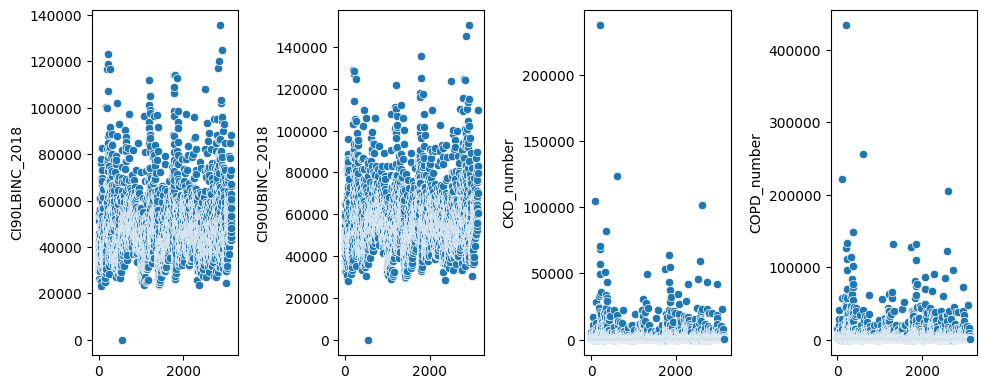

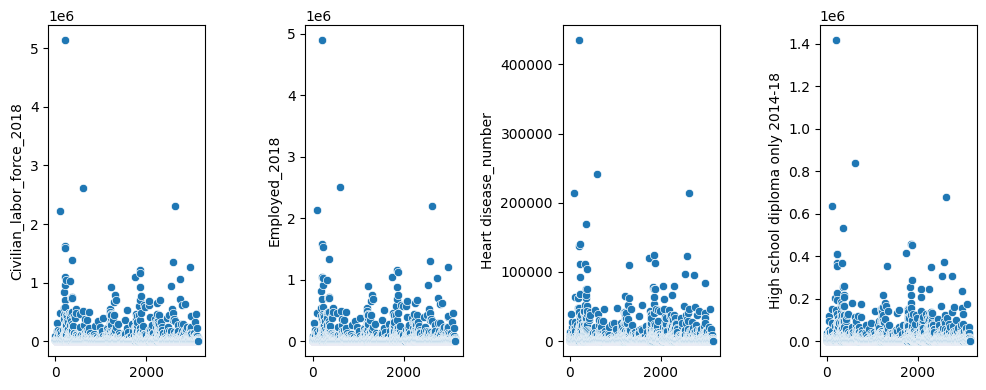

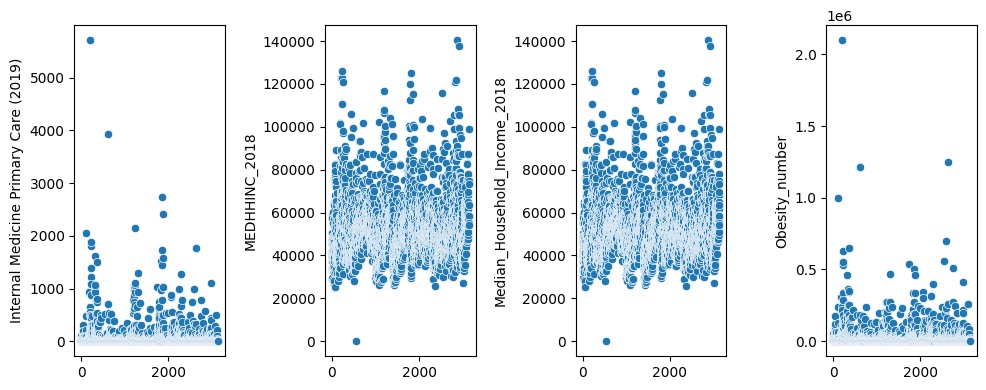

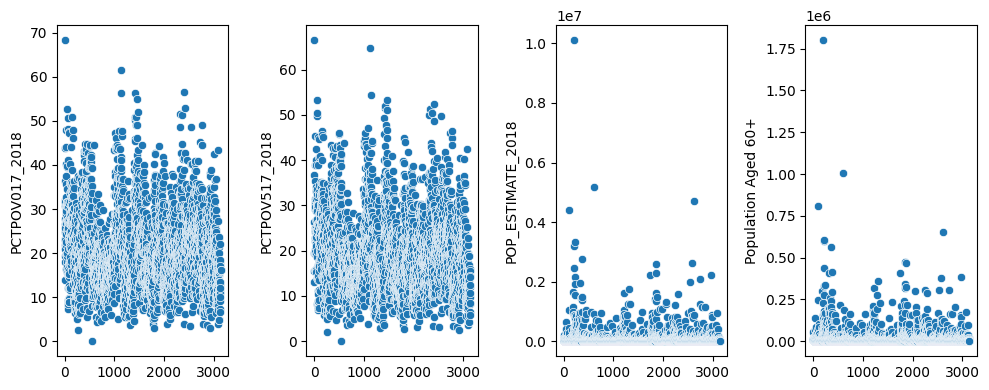

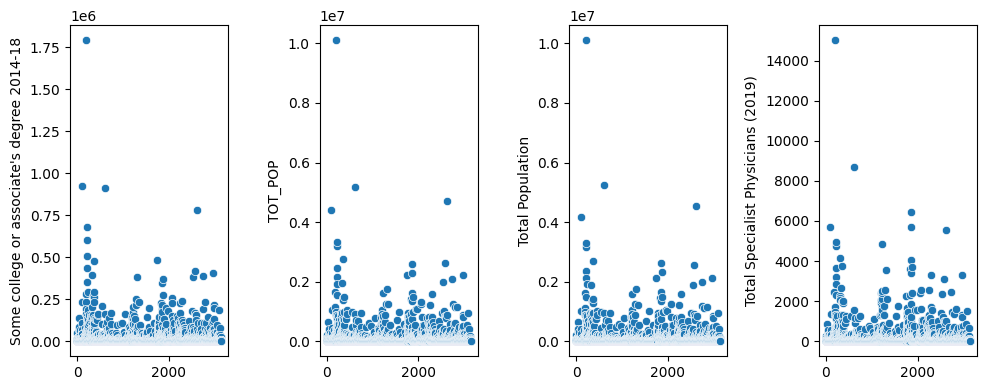

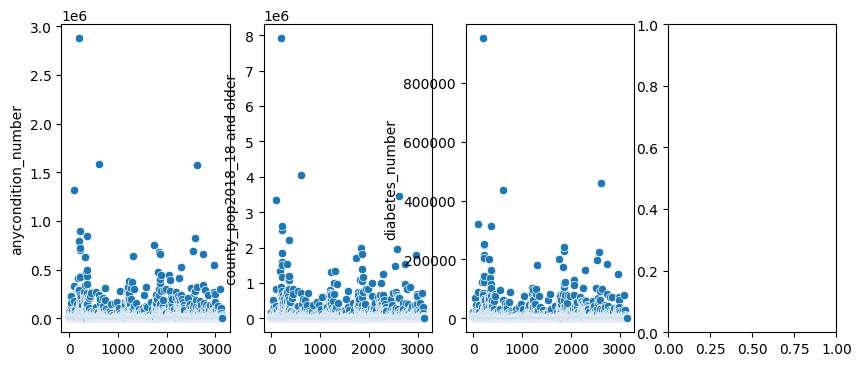

In [18]:
j=0
fig, axis= plt.subplots(1,4,figsize=(10,4))
for i in x_unique:
       
    sns.scatterplot(data3[i],ax=axis[j],)
    j+=1

    if j==4:   
        j=0
        plt.tight_layout()
        plt.show()
        fig, axis= plt.subplots(1,4,figsize=(10,4))



Todas esas variables tienen una correlación muy cercana a 1, eso nos indica que están demasiado relacionadas, por tanto, seguramente una se calcula a través de la otra, esto podemos saberlo si tenemos la definición del dataset. De cara a un modelo predictivo puede enturbiar el modelo si metemos variables que son múltiplo de otras. 

Vamos a escoger una variable objetivo, para poder descartar las que tengan una relación cercana a 1 y empezar con el modelo: *Heart disease_prevalence*

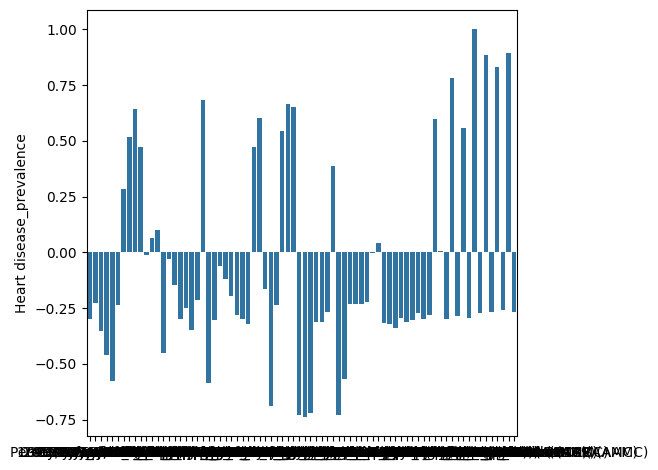

In [19]:
y_name="Heart disease_prevalence"
y_corr=matriz_correlacion[y_name]
sns.barplot(y_corr)
plt.tight_layout()
plt.show()


Como tenemos muchas variables, vamos a descartar las que tengan una correlación por encima de 0.99 y por debajo de 0.25 (en valor absoluto)

In [20]:
y_corr_filter=[(abs(val)>0.25)&(abs(val)<0.99) for val in y_corr]
print(f"Sin filtrar: {len(y_corr)} \t filtrado: {len(y_corr[y_corr_filter])}")

filtro4=y_corr[y_corr_filter].index
filtradas4=y_corr.drop(filtro4,inplace=False)
print(f"Variables eliminadas:\n {filtradas4}")
data4=data3[filtro4]
data4.head()

Sin filtrar: 76 	 filtrado: 54
Variables eliminadas:
 0-9 y/o % of total pop                                                          -0.229493
40-49 y/o % of total pop                                                        -0.236252
% White-alone                                                                   -0.011185
% Black-alone                                                                    0.064700
% NA/AI-alone                                                                    0.102282
% Hawaiian/PI-alone                                                             -0.029712
% Two or more races                                                             -0.147510
N_POP_CHG_2018                                                                  -0.247960
R_birth_2018                                                                    -0.215300
R_DOMESTIC_MIG_2018                                                             -0.060161
R_NET_MIG_2018                                

,TOT_POP,10-19 y/o % of total pop,20-29 y/o % of total pop,30-39 y/o % of total pop,50-59 y/o % of total pop,60-69 y/o % of total pop,70-79 y/o % of total pop,80+ y/o % of total pop,% Asian-alone,POP_ESTIMATE_2018,...,anycondition_number,Obesity_prevalence,Obesity_number,Heart disease_number,COPD_prevalence,COPD_number,diabetes_prevalence,diabetes_number,CKD_prevalence,CKD_number
0,55601,13.735364,12.370281,12.749771,13.917016,10.478229,7.284042,3.622237,1.224798,55601,...,20181,35.8,15193,3345,8.6,3644,12.9,5462,3.1,1326
1,218022,12.344167,10.814964,11.564429,13.753658,13.728890,9.602701,4.296814,1.150343,218022,...,68790,29.7,50761,13414,8.6,14692,12.0,20520,3.2,5479
2,24881,11.896628,13.134520,12.865239,13.174712,12.362847,9.018930,4.212049,0.454162,24881,...,11325,40.7,8013,2159,12.1,2373,19.7,3870,4.5,887
3,22400,11.589286,13.522321,13.897321,13.906250,11.361607,7.691964,3.504464,0.236607,22400,...,9190,38.7,6894,1533,10.0,1789,14.1,2511,3.3,595
4,57840,13.087828,11.656293,11.901798,13.561549,12.041840,8.525242,4.036999,0.319848,57840,...,20584,34.0,15112,4101,10.5,4661,13.5,6017,3.4,1507


**Selección y normalización de dataset reducido**

In [21]:

#separamos el data set
X=pd.DataFrame(data4)

y=data3[y_name]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


Normalizamos los datos 

In [45]:
#Normalizamos los datos 
scaler = StandardScaler()
scaler.fit(X_train)

cols=X.columns
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)

print(round(X_train_norm.describe(),2))
print(round(X_test_norm.describe(),2))

       TOT_POP  10-19 y/o % of total pop  20-29 y/o % of total pop  \
count  2512.00                   2512.00                   2512.00   
mean     -0.00                     -0.00                      0.00   
std       1.00                      1.00                      1.00   
min      -0.30                     -7.10                     -3.96   
25%      -0.27                     -0.57                     -0.58   
50%      -0.23                     -0.00                     -0.17   
75%      -0.11                      0.53                      0.29   
max      27.78                      5.91                      7.18   

       30-39 y/o % of total pop  50-59 y/o % of total pop  \
count                   2512.00                   2512.00   
mean                       0.00                     -0.00   
std                        1.00                      1.00   
min                       -3.30                     -4.99   
25%                       -0.63                     -0.56   
50%

**Realización de modelo de regresión y regresiones regularizadas**

**Comparamos métricas y visualizamos los errores y ajuste**

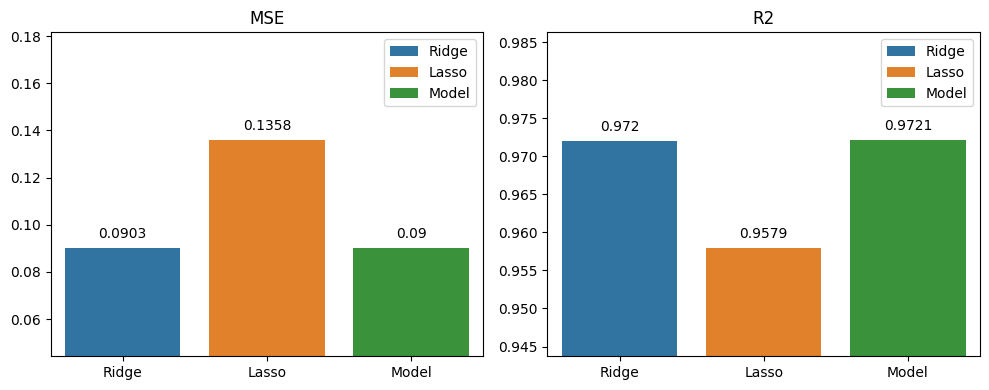

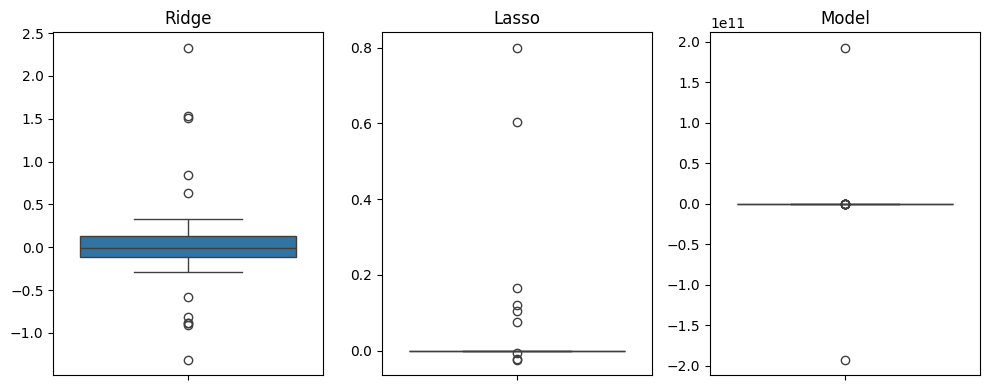

In [44]:
#Regresión
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

#Lasso
lasso_model = Lasso(alpha = 0.1, max_iter = 300)
lasso_model.fit(X_train_norm, y_train)
y_pred_lasso = lasso_model.predict(X_test_norm)

#Ridge
ridge_model = Ridge(alpha = 0.1, max_iter = 300)
ridge_model.fit(X_train_norm, y_train)
y_pred_ridge = ridge_model.predict(X_test_norm)

# Calcular el error cuadrático medio
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
MSE= mean_squared_error(y_test, y_pred)

ridge_r2=r2_score(y_test, y_pred_ridge)
lasso_r2=r2_score(y_test, y_pred_lasso)
R2=r2_score(y_test, y_pred)

valoresMSE=[ridge_mse,lasso_mse,MSE]
valoresR2=[ridge_r2,lasso_r2,R2]
nombs=['Ridge','Lasso','Model']

# Graficamos los datos resultados

fig, axis= plt.subplots(1,2,figsize=(10,4))
ax1=sns.barplot(x=nombs,y=valoresMSE,hue=nombs,ax=axis[0],legend=nombs)
lim0=min(valoresMSE)-(max(valoresMSE)-min(valoresMSE))
lim1=max(valoresMSE)+(max(valoresMSE)-min(valoresMSE))
for p in ax1.patches:
    ax1.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axis[0].set_ylim(lim0,lim1)
axis[0].set_title("MSE")

ax2=sns.barplot(x=nombs,y=valoresR2,hue=nombs,ax=axis[1],legend=nombs)
lim0=min(valoresR2)-(max(valoresR2)-min(valoresR2))
lim1=max(valoresR2)+(max(valoresR2)-min(valoresR2))
for p in ax2.patches:
    ax2.annotate(f'{round(p.get_height(),4)}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


axis[1].set_ylim(lim0,lim1)
axis[1].set_title("R2")

plt.tight_layout()
plt.show()


fig, axis= plt.subplots(1,3,figsize=(10,4))

sns.boxplot(model.coef_,ax=axis[2])
axis[2].set_title("Model")
sns.boxplot(ridge_model.coef_,ax=axis[0])
axis[0].set_title("Ridge")
sns.boxplot(lasso_model.coef_,ax=axis[1])
axis[1].set_title("Lasso")

plt.tight_layout()
plt.show()

Según estos resultados, con el data set último data4 con 54 variables, el modelo arroja un error cuadrático medio de 0.09 y un ajuste con un R2=0.9721. Siendo el modelo de regresión lineal el que mejor ajuste tiene y menores errores en comparación con Ridge y Lasso. 

Sin embargo, la diferencia con la regularización Ridge es mínima, y, si nos fijamos en los coeficientes, son mucho más consistentes ya que los valores están todos más acotados, vemos unos outliers en 2 valores en el modelo que al regularizar no sucede en Ridge.

Por tanto, la mejor opción para el modelo es regularizarlo con Ridge.